In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', color_codes = True)

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [330]:
#ps.head()

In [3]:
ps = ps[["Date", "User", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version", "PCR cycles", "SM_QC_PF", "Resolution index", "Bad dates"]]
#ps.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
ps.dropna(subset = ["Post patch?"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["Bad dates"] != 'x']
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps = ps.drop('Bad dates', 1)
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
#ps["PCR cycles"].value_counts()
ps

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index
4968,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,fail,NaN
4969,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.923406
4970,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,21.0,fail,NaN
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000
4972,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.322631
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631
4974,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN
4978,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,21.0,fail,NaN
4979,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000


#### defining counting functions

In [4]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

#### defining filtering functions

In [5]:
#input is a dataframe

def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

def gen_filter(df, col, cond):
    filtr = df[df[col] == cond]
    return filtr


In [6]:
#total = ps["Post patch?"].count()
total = get_count(ps)
total
ps['Post patch?'].value_counts()

Nucleated             755
No-Seal               556
Partial-Nucleus       204
nucleus_present        93
Outside-Out            92
nucleus_absent         76
Entire-Cell            17
no_nucleus_visible      6
nucleus_visible         4
entire_cell             3
missing                 1
Outside-Out?            0
Nucleus                 0
outside-out             0
Outside-out             0
no -seal                0
no-seal                 0
nr                      0
nucelated               0
Entire cell             0
Name: Post patch?, dtype: int64

# Post patch condition percentages

#### Filtering to nucleated patches only and calculating percentage

In [7]:
#nuc = ps[(ps["Post patch?"] == "Nucleated") | (ps["Post patch?"] == "Partial-Nucleus") | (ps["Post patch?"] == "nucleus_present") | (ps["Post patch?"] == "nucleus_visible")]
#nuc = ps[(ps["Post patch?"] == "Nucleated") | (((ps["Post patch?"] == "nucleus_visible") | (ps["Post patch?"] == "nucleus_present")) & (ps["Post patch pipette R"] >= 500))]
nuc = nucleated(ps)
nuc
class_nuc = nuc["post patch class"] = "Nucleated"
nuc
#nuc["Post patch pipette R"].value_counts()
#dic = {'Nucleated': 'test',
    #  'nucelated': 'Nucleated'
    # }

#ps['Post patch?'] = ps['Post patch?'].map(lambda x: dic[x])

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.601033,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.678447,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,21.0,pass,0.795757,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.556320,Nucleated


In [8]:
#nuc_count = nuc["Post patch?"].count()
nuc_count = get_count(nuc)
nuc_count

831

In [9]:
#nuc_percent = float(nuc_count)/total
#nuc_percent
nuc_pct = calc_pct(nuc, ps) 
print "nucleated patch %:", nuc_pct

nucleated patch %: 0.459878251245


#### Filtering to partial-nucleated patches only and calculating percentage 

In [10]:
part_nuc = partial_nucleated(ps)
class_part_nuc = part_nuc["post patch class"] = "Partial nucleated"
part_nuc
#part_nuc["Post patch pipette R"].value_counts()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,post patch class
4996,2017-04-20,P1,Partial-Nucleus,NaN,NaN,NaN,AiV2,21.0,pass,0.678447,Partial nucleated
5021,2017-04-21,P1,Partial-Nucleus,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,21.0,pass,1.000000,Partial nucleated
5047,2017-04-24,P1,Partial-Nucleus,NaN,NaN,Cell Dimmed lots of small bubbles,AiV2,21.0,fail,NaN,Partial nucleated
5135,2017-04-27,P1,Partial-Nucleus,NaN,NaN,Fluorescence in Pipette lots of small bubbles,AiV2,21.0,fail,NaN,Partial nucleated
5169,2017-04-28,P2,Partial-Nucleus,NaN,NaN,one tiny bubble formed during expulsion.,AiV2,21.0,pass,1.000000,Partial nucleated
5171,2017-04-28,P2,Partial-Nucleus,NaN,NaN,no bubbles during expulsion.,AiV2,21.0,pass,1.000000,Partial nucleated
5188,2017-05-01,P2,Partial-Nucleus,NaN,NaN,Fluorescence in Pipette One big bubble formed ...,AiV2,21.0,pass,NaN,Partial nucleated
5190,2017-05-01,P2,Partial-Nucleus,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,NaN,Partial nucleated
5202,2017-05-01,P6,Partial-Nucleus,NaN,NaN,NaN,AiV2,21.0,fail,NaN,Partial nucleated
5203,2017-05-01,P6,Partial-Nucleus,NaN,NaN,NaN,AiV2,21.0,fail,NaN,Partial nucleated


In [11]:
part_nuc_pct = calc_pct(part_nuc, ps)
print "partial nucleated patch %:", part_nuc_pct

partial nucleated patch %: 0.124515771998


#### Filtering to outside-out patches only and calculating percentage

In [12]:
out_out = outside_out(ps)
class_out_out = out_out["post patch class"] = "Outside out"
out_out
out_out_pct = calc_pct(out_out, ps)
print "outside_out %: ", out_out_pct
#out_out["Post patch pipette R"].value_counts()
#out_out["Post patch?"].value_counts()

outside_out %:  0.0592141671278


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Filtering to no-seal patches only and calculating percentage

In [13]:
noSeal = no_seal(ps)
class_no_seal = noSeal["post patch class"] = "No seal"
noSeal
noSeal_pct = calc_pct(noSeal, ps)
print "no seal %: ", noSeal_pct

no seal %:  0.344216934145


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
frames = [nuc, part_nuc, out_out, noSeal]
result = pd.concat(frames)
result

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.601033,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.678447,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,21.0,pass,0.795757,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.556320,Nucleated


# Calculating nucleated patch percentages by user

In [15]:
P8_total = ps[ps["User"] == 'P8']
P8_total_count = P8_total['Post patch?'].count()
P8_total_count

447

In [16]:
#use post patch nucleated filter
P8_nuc = P8_total[P8_total['Post patch?'] == 'Nucleated']
P8_nuc_count = P8_nuc['Post patch?'].count()
P8_nuc_count

211

In [17]:
float(P8_nuc_count)/P8_total_count

0.4720357941834452

In [18]:
for riguser in ['P1','P2','P6','P8','P9','PA','PB']:
    user_total = ps[ps['User'] == riguser]
    user_nuc = nucleated(user_total)
    user_percent = calc_pct(user_nuc, user_total)
    print riguser,': ', user_percent
    
    #user_total_count = get_count(user_total)
    #user_total_count = user_total['Post patch?'].count()
    #user_nuc = user_total[user_total['Post patch?'] == 'Nucleated']
    #user_nuc_count = get_count(user_nuc)
    #user_nuc_count = user_nuc['Post patch?'].count()
    #user_percent = float(user_nuc_count)/(user_total_count)

P1 :  0.342490842491
P2 :  0.516071428571
P6 :  0.369863013699
P8 :  0.519015659955
P9 :  0.648351648352
PA :  0.53125
PB :  0.311111111111


# Obtaining nucleus dependant on internal solution version

In [19]:
standard = "AiV2"
alexa = "AiV2-50uM alexa 488"
post_patch_condition = ['Nucleated', 'Partial nucleated', 'Outside out', 'No seal']
def postpatch_results(internal):
    internal_version = gen_filter(result, "Internal version", internal)
    internal_version = internal_version[(internal_version["User"] == "P2") | (internal_version["User"] == "P8")]
    #for n in internal_version["post patch class"]:
    for n in post_patch_condition:
        post_patch = gen_filter(internal_version, 'post patch class', n)
        post_patch_pct = calc_pct(post_patch, internal_version)
        print internal, n,': ', post_patch_pct
std = postpatch_results(standard)
alexa488 = postpatch_results(alexa)
std
alexa488

AiV2 Nucleated :  0.516600265604
AiV2 Partial nucleated :  0.124833997344
AiV2 Outside out :  0.0371845949535
AiV2 No seal :  0.321381142098
AiV2-50uM alexa 488 Nucleated :  0.538775510204
AiV2-50uM alexa 488 Partial nucleated :  0.0979591836735
AiV2-50uM alexa 488 Outside out :  0.0530612244898
AiV2-50uM alexa 488 No seal :  0.310204081633


# Rate of SMQC pass by internal solution verion

In [27]:
standard = "AiV2"
alexa = "AiV2-50uM alexa 488"
std_int = gen_filter(ps, "Internal version", standard)
std_int.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
standard_internal_count = std_int["Post patch?"].count()
standard_internal_count

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1384

In [28]:
standard_internal_pass = std_int[std_int["SM_QC_PF"] == "pass"]
standard_internal_pass
standard_internal_pass_count = standard_internal_pass["Post patch?"].count()
standard_internal_pass_count                                    

1079

In [29]:
print "Standard internal pass rate:" , float(standard_internal_pass_count)/standard_internal_count

Standard internal pass rate: 0.779624277457


In [23]:
alexa_int = gen_filter(ps, )
alexa_int.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
alexa_internal_count = alexa_int["Post patch?"].count()
alexa_internal_count

NameError: name 'alexa_int' is not defined

In [303]:
alexa_internal_pass = alexa_int[alexa_int["SM_QC_PF"] == "pass"]
alexa_internal_pass_count = alexa_internal_pass["Post patch?"].count()
alexa_internal_pass_count

150

In [304]:
print "Alexa internal pass rate:" , float(alexa_internal_pass_count)/alexa_internal_count

Alexa internal pass rate: 0.797872340426


# Rate of SM_QC pass based on internal version and post patch condition

In [24]:
result.dropna(subset = ["SM_QC_PF"], inplace=True)
standard = "AiV2"
alexa = "AiV2-50uM alexa 488"
post_patch_condition = ['Nucleated', "Partial nucleated", "Outside out", "No seal"]
def pass_pct_results(internal):
    int_ver = gen_filter(result, "Internal version", internal)
    int_ver = int_ver[(int_ver["User"] == "P2") | (int_ver["User"] == "P8")]
    for n in post_patch_condition:
        post_patch = gen_filter(int_ver,"post patch class", n)
        post_patch_pass = pass_only(post_patch)
        post_patch_pass_pct = calc_pct(post_patch_pass, post_patch)
        print internal, n,': ', post_patch_pass_pct
pass_pct_results(standard)
pass_pct_results(alexa)

 AiV2 Nucleated :  0.917525773196
AiV2 Partial nucleated :  0.904255319149
AiV2 Outside out :  0.785714285714
AiV2 No seal :  0.797520661157
AiV2-50uM alexa 488 Nucleated :  0.965217391304
AiV2-50uM alexa 488 Partial nucleated :  0.705882352941
AiV2-50uM alexa 488 Outside out :  0.5
AiV2-50uM alexa 488 No seal :  0.480769230769


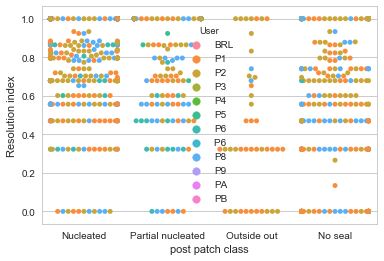

In [26]:
sns.swarmplot(x='post patch class', y='Resolution index', hue='User', data=result)